# Dimensionality Reduction

An alternative approach to feature selection for dimensionality reduction is feature extraction. We can summarize the information content of a dataset by transforming it onto a new feature subspace of lower dimensionality than the original one. There are multiple ways to accomplish this:
 - Principal component analysis for unsupervised data compression
 - Linear discriminant analysis as a supervised dimensionality reduction technique for maximizing class separability
 - Nonlinear dimensionality reduction techniques, such as t-distributed stochastic neighbor embedding for data visualization
 
### Principal Components Analysis

The goal of PCA is to find the directions of maximum variance in the dataset (given that they are orthogonal) and project the data onto a new subspace with fewer dimensions than the original dataset. Suppose that the original feature space $X$ has $n$ observations and $d$ features. Then we will construct a $d\times k$-dimensional matrix $W$ so that
$$
Z=\mathbf{X}\mathbf{W}
$$
is an $n\times k$-dimensional matrix which captures the largest possible amount of variance in the original dataset under the constraint that all new features (called principal components) are mutually orthogonal.

The approach for PCA is as follows:
1. Standardize the $d$-dimensional feature set $X$.
2. Construct the covariance matrix $X^\top X$.
3. Decompose the covariance matrix into its eigenvectors and eigenvalues.
4. Sort the eigenvectors by the absolute value of their eigenvalues.
5. Select the $k\leq d$ eigenvectors with largest eigenvalues.
6. Construct a projection matrix $W$ whose columns are the top eigenvectors.
7. Transform the input set $X$ by multiplying it with $W$.

In [5]:
import pandas as pd

#load wine dataset from UCI ML archive
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',\
                   'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',\
                   'Proanthocyanins', 'Color intensity', 'Hue',\
                   'OD280/OD315 of diluted wines', 'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#separate out class labels from features
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

#perform stratified 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

#standardize the features
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train) #only fit on training set
X_test_std = ss.transform(X_test)

Now, we can use various linear algebra features from the `numpy` library to perform the next steps.

In [7]:
import numpy as np

#construct covariance matrix W
cov_matrix = np.cov(X_train_std.T)

#compute eigenvectors and eigenvalues of W
evals, evecs = np.linalg.eigh(cov_matrix)
print(evals)

[0.09544816 0.14241154 0.22087117 0.25909606 0.26741076 0.31659155
 0.59696802 0.70002767 0.91388156 0.95025687 1.44251124 2.5174937
 4.68272277]


Next, we calculate the explained variance ratio for each eigenvector, to see how much of the variance of the original dataset is captured by taking the first $k$ eigenvectors for all $k\in\{1,2,\ldots,d\}$. To do so, we take
$$
\text{EVR}=\frac{\lambda_k}{\sum_{i=i}^d \lambda_i}.
$$

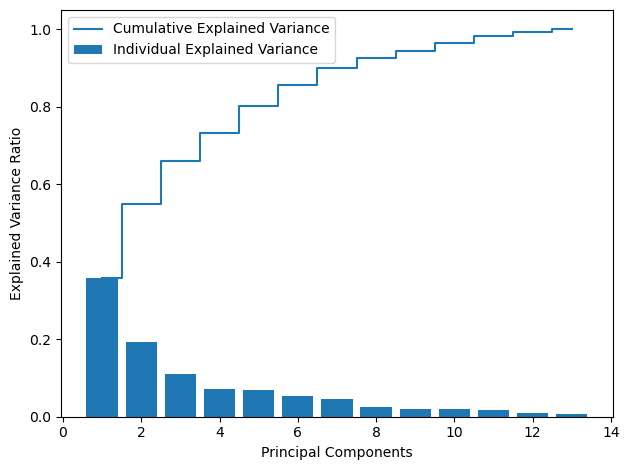

In [8]:
#create list with cumulative explained variance
exp_var = [(i/sum(evals)) for i in sorted(evals, reverse=True)]
cum_exp_var = np.cumsum(exp_var)

import matplotlib.pyplot as plt

#create plot
plt.bar(range(1,14), exp_var, align='center', label='Individual Explained Variance')
plt.step(range(1,14), cum_exp_var, where='mid', label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

For our demonstration purposes, we will only choose the first two principal components.

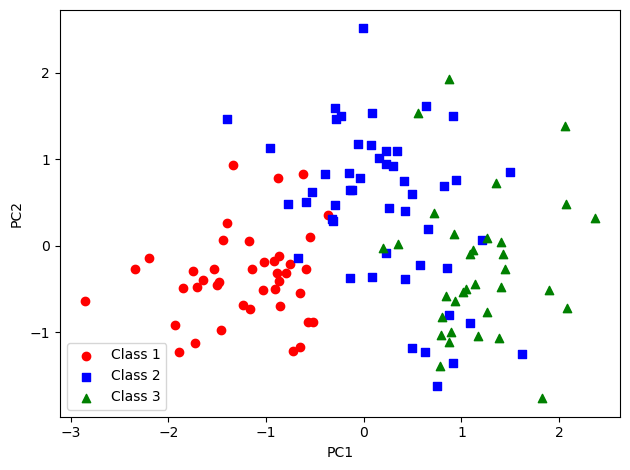

In [9]:
#create projection matrix W
W_matrix = np.hstack((evecs[12][:, np.newaxis],
                      evecs[11][:, np.newaxis]))

#create final PCA matrix by dotting X with W
X_train_pca = X_train_std.dot(W_matrix)

#now visualize the class separation
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
               X_train_pca[y_train==l, 1],
               c=c, label=f'Class {l}', marker=m)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

We can now implement PCA in a less verbose way using the `sklearn` library, and then we will test out the function we just created above to see how PCA combined with logistic regression performs on the standardized training set.

We have also made a function that allows us to plot the decision regions prescribed by the classifier of our choice in the file `decision_regions.py`, which we will import to help us visualize the performance of the model we've created.

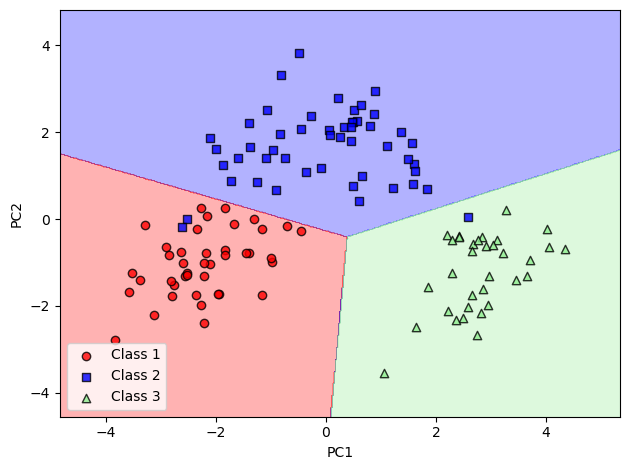

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from decision_regions import plot_decision_regions

#initialize pca and logit objects
pca = PCA(n_components=2)
logit = LogisticRegression(multi_class='ovr', random_state=42, solver='lbfgs')

#fit pca and project into lower-dimensional subspace
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

#fit logit on lower-dimensional dataset
logit.fit(X_train_pca, y_train)

#plot decision regions
plot_decision_regions(X_train_pca, y_train, classifier=logit)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

We can also check how the logistic regression classifier performs on the test set.

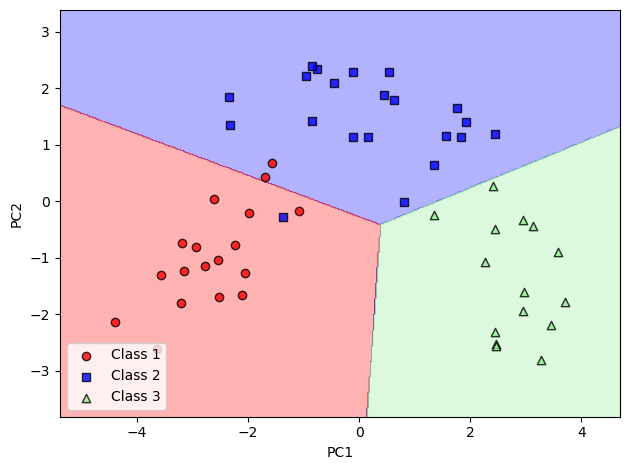

In [11]:
plot_decision_regions(X_test_pca, y_test, classifier=logit)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

Visually, it appears that only a few instances are misclassified. We can check the accuracy on the test set.

In [12]:
y_pred = logit.predict(X_test_pca)
test_acc = logit.score(X_test_pca, y_test)
print('Test accuracy: {}'.format(test_acc))

Test accuracy: 0.9444444444444444


We can find the explained variance ratios for each principal component by setting `n_components=None` and then accessing the `explained_variance_ratio_` atrribute of the PCA object.

In [13]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.35730453, 0.19209164, 0.11006755, 0.07250719, 0.06973166,
       0.05341402, 0.04555029, 0.0241568 , 0.02040417, 0.01976974,
       0.01685307, 0.01086639, 0.00728295])

Recall that PCA creates principal components which are linear combinations of the features in our dataset. We are often interested in which features contribute to the largest principal components. These contributions are referred to as *loadings*, and can be computed by multiplying the eigenvectors by the square root of the eigenvalues.

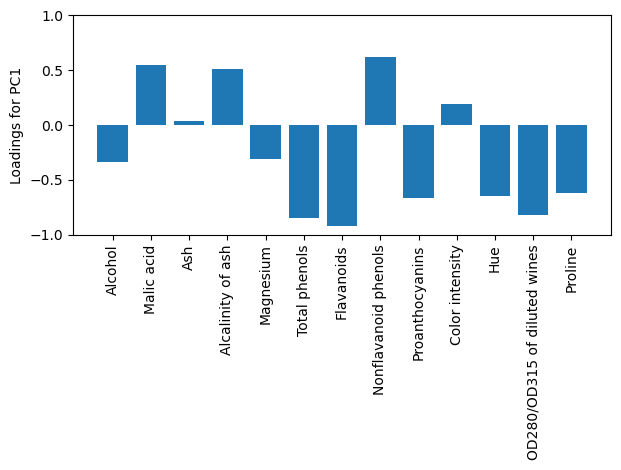

In [14]:
#compute loadings
loadings = evecs * np.sqrt(evals)

#plot loadings for largest component
fig, ax = plt.subplots()
ax.bar(range(13), loadings[:, 12], align='center')
ax.set_ylabel('Loadings for PC1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

We can compute the `sklearn` loadings in much the same way, noting that the `components_` attribute represents the eigenvectors of the covariance matrix and the `explained_variance_` attribute represents the eigenvectors.

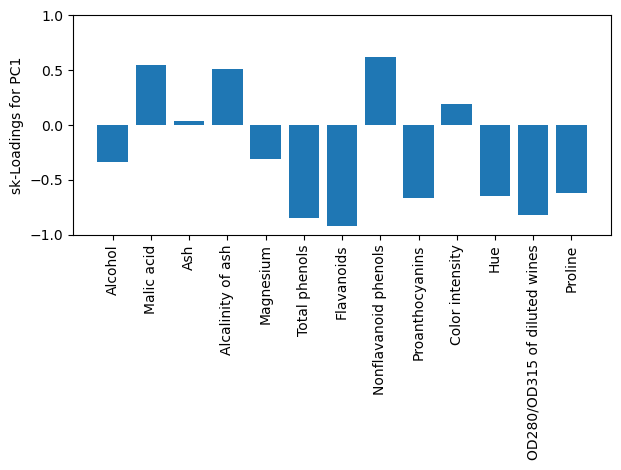

In [15]:
#compute sklearn loadings
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

#plot sklearn loadings
fig, ax = plt.subplots()
ax.bar(range(13), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('sk-Loadings for PC1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

Observe that the two plots above are identical!

### Linear Discriminant Analysis

A method of supervised dimensionality reduction which can be applied to a classification problem is linear discriminant analysis (LDA). The goal of LDA is to find the feature subspace which optimizes class separability. There are a few major assumptions in LDA: we assume that the data is normally distributed, that the classes have identical covariance matrices, and that the training examples are statistically independent of each other. However, even if these assumptions are violated slightly, LDA can still work reasonably well.

The main steps required for LDA are:
1. Standardize the $d$-dimensional dataset, where $d$ is the number of features.
2. For each class, compute the $d$-dimensional mean vector.
3. Construct the between-class scatter $\mathbf{S}_B$, and the within-class scatter matrix $\mathbf{S}_W$.
4. Compute the eigenvectors and corresponding eigenvalues of the matrix $\mathbf{S}_W^{-1}\mathbf{S}_B$.
5. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
6. Choose the $k$ eigenvectors that correspond to the largest $k$ eigenvalues to construct a $d\times k$-dimensional transformation matrix $\mathbf{W}$ whose columns are the eigenvectors.
7. Project the examples onto the new feature subspace using the transformation matrix $\mathbf{W}$.

We will apply LDA to the wine dataset we loaded in above. We already standardized the features above, so we can compute the three mean vectors, one for each class. Each mean vector $\mathbf{m}_i$ stores the mean feature value $\mu_m$ with respect to the examples of class $i$:
$$
\mathbf{m}_i = \frac{1}{n_i}\sum_{\mathbf{x}\in D_i} \mathbf{x}_m.
$$
This results in three mean vectors
$$
\mathbf{m}_i = \begin{bmatrix}
\mu_{i, \text{alcohol}} \\
\mu_{i, \text{malic acid}} \\
\vdots \\
\mu_{i, \text{proline}}
\end{bmatrix}^\top, \quad i\in\{1,2,3 \}.
$$

We implement this below.

In [16]:
#print floats to 4 decimal places
np.set_printoptions(precision=4)

#create mean vectors
mean_vecs = []

for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print(f'MV {label}: {mean_vecs[label-1]} \n') #print each vector

MV 1: [ 0.9585 -0.322   0.3219 -0.7607  0.4346  0.8574  0.9809 -0.4969  0.4261
  0.2418  0.4251  0.7139  1.1879] 

MV 2: [-0.8829 -0.3073 -0.4875  0.2536 -0.323  -0.0632  0.0417 -0.0784  0.185
 -0.8575  0.4598  0.2946 -0.7075] 

MV 3: [ 0.1468  0.8657  0.3387  0.5609 -0.0506 -0.9695 -1.282   0.7362 -0.8096
  0.9987 -1.2249 -1.3334 -0.4039] 



We compute the individual scatter matrices $\mathbf{S}_i$ for each class $i$:
$$
\mathbf{S}_i = \sum_{x\in\mathbf{D}_i} (\mathbf{x}-\mathbf{m}_i)(\mathbf{x}-\mathbf{m}_i)^\top.
$$
We then compute the within-class scatter matrix $\mathbf{S}_W$ by summing up the individual scatter matrices:
$$
\mathbf{S}_W = \sum_{i=1}^c \mathbf{S}_i
$$
Observe that we want to scale the individual scatter matrices $\mathbf{S}_i$ before we sum them up, because we don't know that the class labels are uniformly distributed across the dataset (i.e., we don't know that there are the same number of instances in each class). Thus, we divide the scatter matrices by the number of instances in the corresponding class $n_i$, which is in fact the same as computing the covariance matrix:
$$
\frac{1}{n_i}\mathbf{S}_i = \frac{1}{n_i}\sum_{x\in\mathbf{D}_i} (\mathbf{x}-\mathbf{m}_i)(\mathbf{x}-\mathbf{m}_i)^\top = \Sigma_i.
$$

In [17]:
d = 13 #number of features
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter

We now compute the between-class scatter matrix $\mathbf{S}_B$ using the overall mean vector $\mathbf{m}$ which includes all instances of a given feature:
$$
\mathbf{S}_B = \sum_{i=1}^c n_i(\mathbf{m}_i-\mathbf{m})(\mathbf{m}_i-\mathbf{m})^\top.
$$

In [18]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)

S_B = np.zeros((d, d))

for i, mv in enumerate(mean_vecs):
    n = X_train_std[y_train==i+1, :].shape[0]
    mv = mv.reshape(d, 1)
    S_B += n * (mv - mean_overall).dot((mv - mean_overall).T)

Now we perform an eigendecomposition on the matrix $\mathbf{S}_W^{-1}\mathbf{S}_B$.

In [19]:
evals, evecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

#create eigenpairs sorted
epairs = [(np.abs(evals[i]), evecs[:,i]) for i in range(len(evals))]
epairs = sorted(epairs, key=lambda k:k[0], reverse=True)

#print out the sorted eigenvalues
for eig in epairs:
    print(eig[0])

418.49988288057716
204.5747764260586
4.235893463568819e-14
2.842170943040401e-14
2.2904441213521698e-14
2.2904441213521698e-14
1.807639284910422e-14
1.739744894516524e-14
1.7240420301387857e-14
4.716489301320688e-15
4.716489301320688e-15
2.359526040523811e-15
1.9466546701407593e-15


In LDA, the number of linear discriminants is at most $c-1$, where $c$ is the number of classes, because the in-between scatter matrix $\mathbf{S}_B$ is the sum of $c$ matrices with rank one or less. We can see above that we do indeed have only two nonzero eigenvalues, with the remaining eigenvalues only appearing to be nonzero due to floating-point arithmetic in `numpy`.

We now make our projection matrix $\mathbf{W}$ and project our standardized data onto the new feature space.

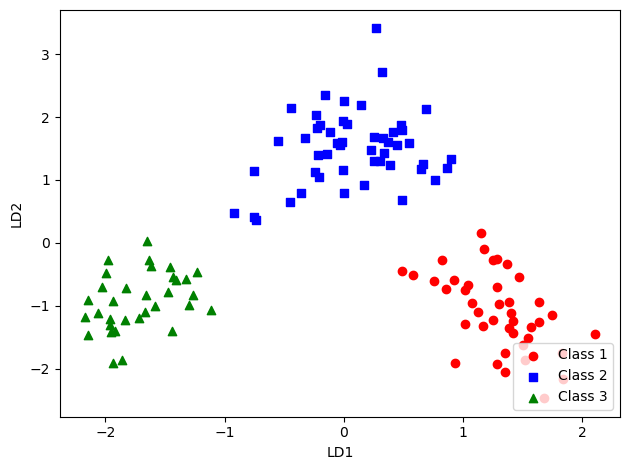

In [20]:
#make projection matrix
W = np.hstack((epairs[0][1][:, np.newaxis].real,
              epairs[1][1][:, np.newaxis].real))

#transform features
X_train_lda = X_train_std.dot(W)

#create plot of classes, check if they're linearly separable now
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m, in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
               X_train_lda[y_train==l, 1],
               c=c, label=f'Class {l}', marker=m)

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Finally, we look at how to implement LDA using `sklearn` and apply a logistic regression model to the newly transformed, lower-dimensional feature space.

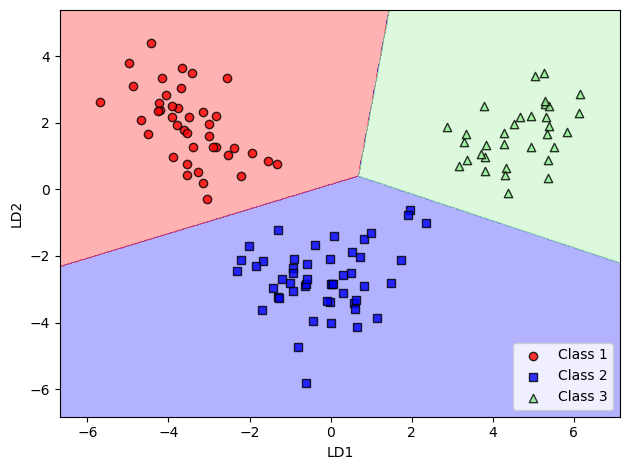

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#create instance of LDA class
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

#create logistic regression object
lr = LogisticRegression(multi_class='ovr', random_state=42, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

#plot decision regions
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

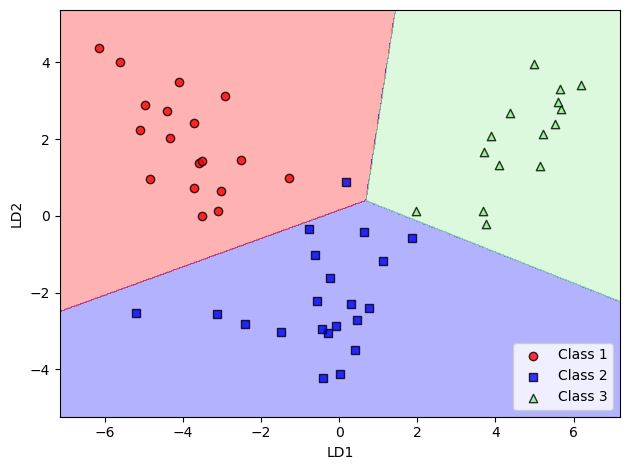

In [22]:
#see how the classifier performs on the test set
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

We can see from the above that only one test instance is misclassified. We verify this below.

In [23]:
#find test accuracy
test_acc = lr.score(X_test_lda, y_test)
print(test_acc)

0.9814814814814815


In this case, using logistic regression as our classifier, we find that LDA has outperformed PCA as a dimensionality reduction technique in terms of accuracy on the test set.

### Nonlinear Dimensionality Reduction

Note that linear dimensionality reduction techniques such as PCA assume that the data are linearly separable, and that the lack of perfect linear separability is due to noise. However, many datasets may contain classes which are not linearly separable.

To deal with such datasets, multiple nonlinear dimensionality reduction techniques have been developed, often referred to as *manifold learning*. A manifold is a lower dimensional topological space embedded in a high-dimensional space. Such manifold learning algorithms have to learn the complicated structure of the dataset in order to project it into a lower-dimensional space while preserving the essential relationships between the data points. Unfortunately, such algorithms are currently unreliable and require careful tuning of hyperparameters to get decent results. Because of this, linear dimensionality reduction is still widely used, and nonlinear dimensionality reduction is often relegated to use in visualizing data.

One example that we can implement with `sklearn` is t-distributed stochastic neighbor embedding, or t-SNE. This is often used for visualizing complex datasets in two or three dimensions. Essentially, t-SNE models data points based on their pair-wise distances in the original, high-dimensional feature space. Then, it finds a probability distribution of pair-wise distances in the new, lower-dimensional feature space that is close to the probability distribution of pair-wise distances in the original space.

Importantly, t-SNE is intended for visualization purposes as it requires the whole dataset for projection. Since it projects the points directly (unlike PCA, it does NOT involve a projection matrix), we cannot apply t-SNE to new data points.

Below, we will apply t-SNE to the Digits dataset in `sklearn`, which is a $64$-dimensional dataset consisting of low-resolution handwritten digits (i.e. the numbers $0$-$9$).

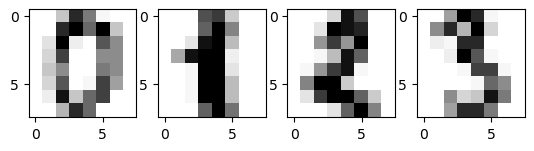

In [24]:
from sklearn.datasets import load_digits

#import digits dataset
digits = load_digits()

#plot first four images in dataset
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(digits.images[i], cmap='Greys')
plt.show()

In [25]:
#check the dimensionality of the dataset
digits.data.shape

(1797, 64)

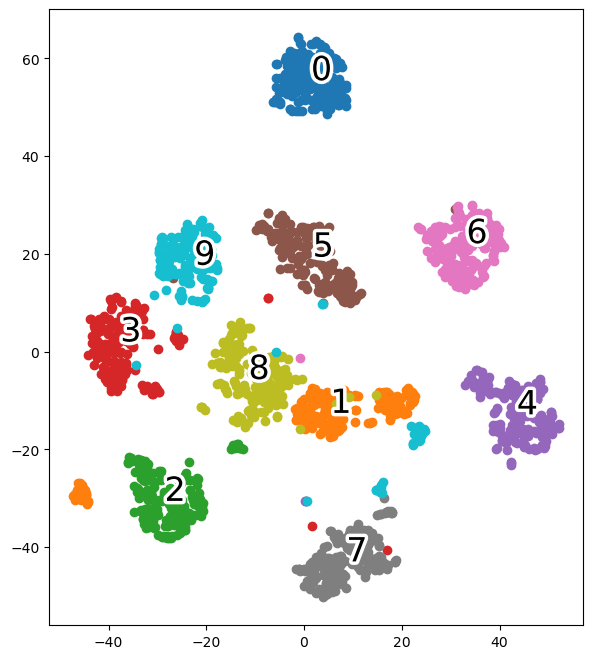

In [26]:
#separate out features and labels
y_digits = digits.target
X_digits = digits.data


#apply t-SNE to features
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=42)
X_digits_tsne = tsne.fit_transform(X_digits)

#visualize the t-SNE embeddings in 2D
import matplotlib.patheffects as PathEffects

def plot_projection(x, colors):
    
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    for i in range(10):
        plt.scatter(x[colors == i, 0], x[colors == i, 1])
    
    for i in range(10):
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground='w'),
            PathEffects.Normal()
        ])
        
plot_projection(X_digits_tsne, y_digits)
plt.show()

In the above we chose to initialize the t-SNE embedding using PCA as recommended in the paper *Initialization is Critical for Preserving Global Data Structure in both t-SNE and UMAP* by Kobak and Linderman. There are other hyperparameters such as perplexity and learning rate (often called epsilon) which should also be tuned if one is going to use t-SNE. We have omitted these and are simply employing the default values here.